# **FINAL PROJECT - Chocolate bar rating dataset**

Naama Kashani 312400476
<p>
Tal Ishon 315242297

imports

In [408]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import plot_tree
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score


In [409]:
df= pd.read_csv( "/content/chocolate_dataset.csv")
df.shape

(1795, 9)

# **Analyze the dataset**

In [410]:
df.dtypes

Company \n(Maker-if known)            object
Specific Bean Origin\nor Bar Name     object
REF                                    int64
Review\nDate                           int64
Cocoa\nPercent                        object
Company\nLocation                     object
Rating                               float64
Bean\nType                            object
Broad Bean\nOrigin                    object
dtype: object

We can see that there are mixture of data types.

In [411]:
#view few samples
df.head()

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


Viewing the data reveal the types, we can see numeric and textual data types.

We renamed the column names to be more significant.

In [412]:
## rename columns and replace % to be float number
original_colnames = df.columns
new_colnames = ['company', 'chocolate_bar_origin', 'REF', 'review_year', 'cocoa_p',
                'company_location', 'rating', 'bean_type', 'bean_origin']
df = df.rename(columns=dict(zip(original_colnames, new_colnames)))
## And modify data types
df['cocoa_p'] = df['cocoa_p'].str.replace('%','').astype(float)/100
df.head()

,company,chocolate_bar_origin,REF,review_year,cocoa_p,company_location,rating,bean_type,bean_origin
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,0.70,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,0.70,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,0.70,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,,Peru


In [413]:
# Check for missing values in each column
missing_per_column = df.isnull().any()

# Filter the columns that contain missing values
columns_with_missing_values = missing_per_column[missing_per_column]

# Print the names of columns with missing values
print("Columns with missing values:")
print(columns_with_missing_values.index.tolist())

Columns with missing values:
['bean_type', 'bean_origin']


Missing values are identified within the "bean type" and "broad bean origin (country)" columns we will handel that issue.


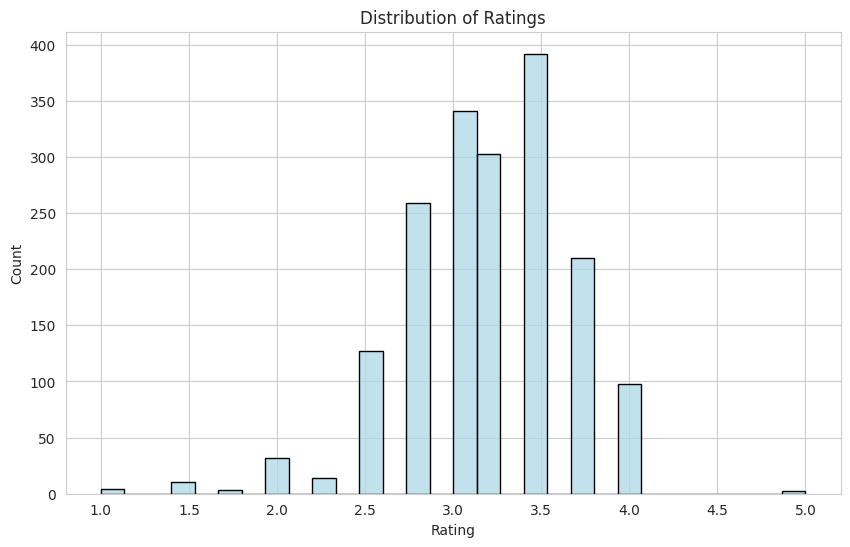

In [414]:
# Set plot style
sns.set_style("whitegrid")

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'],  bins=30, color="lightblue", edgecolor="black")

# Set labels and title
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")

# Show plot
plt.show()

The majority of samples exhibit ratings within the 2.5 to 4 range. Imbalanced ratings characterize a non-uniform distribution across the dataset. This issue will be handled when predicting ratings.

In [415]:
print(df['bean_origin'].sort_values().unique())

['Africa, Carribean, C. Am.' 'Australia' 'Belize' 'Bolivia' 'Brazil'
 'Burma' 'Cameroon' 'Carribean' 'Carribean(DR/Jam/Tri)'
 'Central and S. America' 'Colombia' 'Colombia, Ecuador' 'Congo'
 'Cost Rica, Ven' 'Costa Rica' 'Cuba' 'DR, Ecuador, Peru'
 'Dom. Rep., Madagascar' 'Domincan Republic' 'Dominican Rep., Bali'
 'Dominican Republic' 'Ecuador' 'Ecuador, Costa Rica' 'Ecuador, Mad., PNG'
 'El Salvador' 'Fiji' 'Gabon' 'Ghana' 'Ghana & Madagascar'
 'Ghana, Domin. Rep' 'Ghana, Panama, Ecuador'
 'Gre., PNG, Haw., Haiti, Mad' 'Grenada' 'Guat., D.R., Peru, Mad., PNG'
 'Guatemala' 'Haiti' 'Hawaii' 'Honduras' 'India' 'Indonesia'
 'Indonesia, Ghana' 'Ivory Coast' 'Jamaica' 'Liberia' 'Mad., Java, PNG'
 'Madagascar' 'Madagascar & Ecuador' 'Malaysia' 'Martinique' 'Mexico'
 'Nicaragua' 'Nigeria' 'PNG, Vanuatu, Mad' 'Panama' 'Papua New Guinea'
 'Peru' 'Peru(SMartin,Pangoa,nacional)' 'Peru, Belize' 'Peru, Dom. Rep'
 'Peru, Ecuador' 'Peru, Ecuador, Venezuela' 'Peru, Mad., Dom. Rep.'
 'Peru, Madagascar

We've noticed that certain bean origins are labeled inconsistently, using different names. Additionally, there are instances where the bean origin comprises multiple locations in some samples. We'll need to address this through feature engineering by appropriately separating them.The same problem happens in chocolate_bar_origin column.

We've observed that the 'country' column contains free-form text that lacks consistency. To address this issue, we'll need to perform feature engineering on this column to standardize its values.

In [416]:

# Text preparation (correction) func
def txt_prep(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        text = re.sub(i, j, text)
    return text

# **Data-preprocess**

Make the names in bean_origin consistent

In [417]:
## Replace bean_origin
df['bean_origin'] = df['bean_origin'].astype(str)
df['bean_origin'] = df['bean_origin'].str.replace('.', '').apply(txt_prep)

In [418]:
print(df['company_location'].sort_values().unique())

['Amsterdam' 'Argentina' 'Australia' 'Austria' 'Belgium' 'Bolivia'
 'Brazil' 'Canada' 'Chile' 'Colombia' 'Costa Rica' 'Czech Republic'
 'Denmark' 'Domincan Republic' 'Ecuador' 'Eucador' 'Fiji' 'Finland'
 'France' 'Germany' 'Ghana' 'Grenada' 'Guatemala' 'Honduras' 'Hungary'
 'Iceland' 'India' 'Ireland' 'Israel' 'Italy' 'Japan' 'Lithuania'
 'Madagascar' 'Martinique' 'Mexico' 'Netherlands' 'New Zealand'
 'Niacragua' 'Nicaragua' 'Peru' 'Philippines' 'Poland' 'Portugal'
 'Puerto Rico' 'Russia' 'Sao Tome' 'Scotland' 'Singapore' 'South Africa'
 'South Korea' 'Spain' 'St. Lucia' 'Suriname' 'Sweden' 'Switzerland'
 'U.K.' 'U.S.A.' 'Venezuela' 'Vietnam' 'Wales']


we can see that in company_location column there are some values we need to rename.

In [419]:
df['company_location'] = df['company_location']\
.str.replace('Amsterdam', 'Holland')\
.str.replace('U.K.', 'England')\
.str.replace('Niacragua', 'Nicaragua')\
.str.replace('Domincan Republic', 'Dominican Republic')

# **Features preprocess**

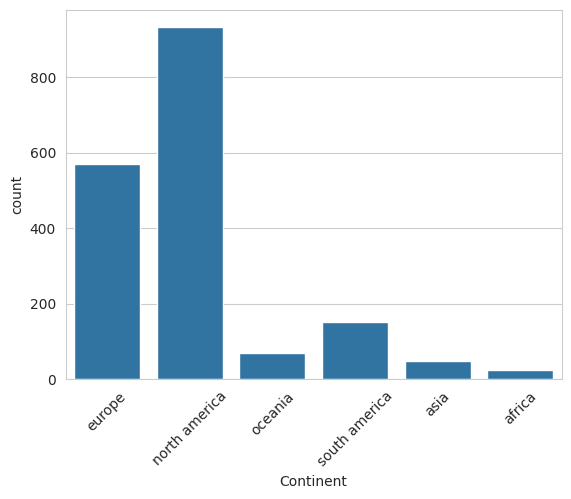

In [420]:
asia = ['Japan', 'Vietnam', 'Israel', 'South Korea', 'Singapore', 'India', 'Philippines', 'Russia']
africa = ['Madagascar', 'Sao Tome', 'South Africa', 'Ghana']
north_america = ['U.S.A.', 'Canada', 'Martinique', 'Niacragua', 'Guatemala', 'St. Lucia', 'Puerto Rico', 'Mexico', 'Costa Rica', 'Honduras', 'Nicaragua', 'Domincan Republic', ]
south_america = ['Ecuador', 'Eucador', 'Colombia', 'Suriname', 'Bolivia', 'Venezuela', 'Chile', 'Peru', 'Brazil', 'Argentina', 'Lithuania']
europe = ['France', 'Denmark', 'Scotland', 'Wales', 'Czech Republic', 'Finland', 'Ireland', 'Portugal', 'Netherlands', 'Poland', 'Amsterdam', 'Sweden', 'U.K.', 'Italy', 'Belgium', 'Switzerland', 'Germany', 'Austria', 'Spain', 'Hungary', ]
oceania = ['Australia', 'New Zealand', 'Fiji']
def continents(x):
    if x in asia:
        return 'asia'
    if x in africa:
        return 'africa'
    if x in north_america:
        return 'north america'
    if x in south_america:
        return 'south america'
    if x in europe:
        return 'europe'
    if x in oceania:
        return 'oceania'
    return 'europe'
df['Continent'] = df['company_location'].apply(continents)
df['Continent'].value_counts()
plt.xticks(rotation=45)
sns.countplot(x='Continent', data=df)
plt.show()

we add column of continent and we can see that most of the samples came from euorpe and north america.

In [421]:
df['chocolate_bar_origin'].value_counts()

chocolate_bar_origin
Madagascar                        57
Peru                              45
Ecuador                           42
Dominican Republic                37
Venezuela                         21
                                  ..
Conacado, #213, DR, -C             1
Sambirano Valley, #215, MR, MC     1
Chuao, #218, MR, MC                1
Chuao, #217, DR, MC                1
Brazil, Mitzi Blue                 1
Name: count, Length: 1039, dtype: int64

In [422]:
df.drop(['chocolate_bar_origin'], axis=1, inplace=True)

We chose to drop that column because we think that it is not adding necessery information for the rating




In [423]:
df['REF'].unique().shape

(440,)

# **Data visualizations**
After the pre-processing we applied on our data, let's visualize it and check if there is more processing needed in our data (such as dropping unnecessarily columns etc)



Visualize the distribution of bean_type when bean_origin is mixed.

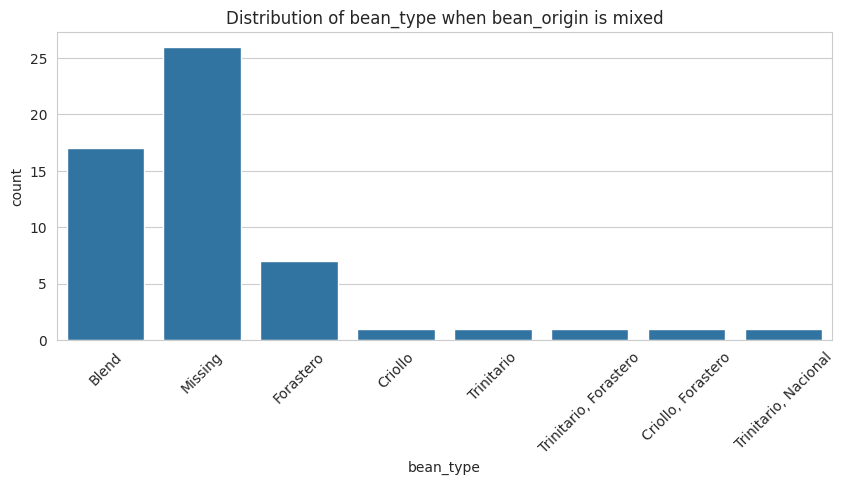

In [424]:
# Filter for rows with multiple values in "bean_origin"
filtered_df = df[df['bean_origin'].str.contains(',')].copy()  # Use copy() to create a copy of the DataFrame
filtered_df.loc[:, 'bean_type'] = filtered_df['bean_type'].replace('\xa0', "Missing")
filtered_df.loc[:, 'bean_type'] = filtered_df['bean_type'].replace('nan', "Missing")
# Look at distribution of bean_type
fig, ax = plt.subplots(figsize=[10, 4])
sns.countplot(data=filtered_df, x='bean_type', ax=ax)
ax.set_title('Distribution of bean_type when bean_origin is mixed')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

If we have multiple values in attribute “bean_origin” (mixed) we notice that the “bean_type” value is mostly ‘Blend’ or ‘missing’ or has more than one value in “bean_type”. (Maybe we could fill the missing values in “bean_type” to ‘blend’ according to this insight).

check the distribution of bean_type when bean_origin is missing

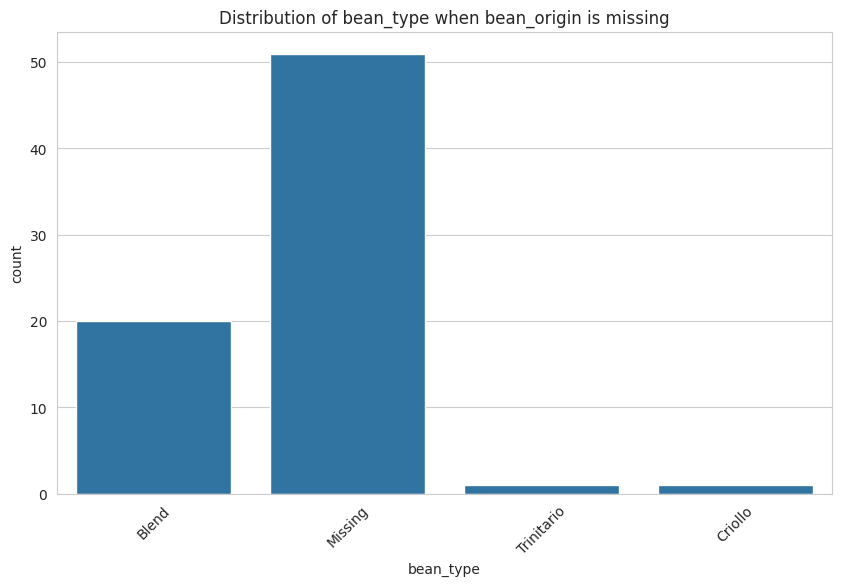

In [425]:
missing_df = df[df['bean_origin'].isna() | (df['bean_origin'] == " ")].copy()
missing_df.loc[:, 'bean_type'] = missing_df['bean_type'].replace('\xa0', "Missing")
missing_df.loc[:, 'bean_type'] = missing_df['bean_type'].replace('nan', "Missing")
fig, ax = plt.subplots(figsize=[10, 6])
sns.countplot(data=missing_df, x='bean_type', ax=ax)
ax.set_title('Distribution of bean_type when bean_origin is missing')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


 When we have ‘missing’ in “bean_origin” it most likely means that the “bean_type” is either ‘Blend’ or ‘missing ’.

In [426]:
print(df['bean_type'].sort_values().unique())

['Amazon' 'Amazon mix' 'Amazon, ICS' 'Beniano' 'Blend'
 'Blend-Forastero,Criollo' 'CCN51' 'Criollo' 'Criollo (Amarru)'
 'Criollo (Ocumare 61)' 'Criollo (Ocumare 67)' 'Criollo (Ocumare 77)'
 'Criollo (Ocumare)' 'Criollo (Porcelana)' 'Criollo (Wild)' 'Criollo, +'
 'Criollo, Forastero' 'Criollo, Trinitario' 'EET' 'Forastero'
 'Forastero (Amelonado)' 'Forastero (Arriba)' 'Forastero (Arriba) ASS'
 'Forastero (Arriba) ASSS' 'Forastero (Catongo)' 'Forastero (Nacional)'
 'Forastero (Parazinho)' 'Forastero(Arriba, CCN)' 'Forastero, Trinitario'
 'Matina' 'Nacional' 'Nacional (Arriba)' 'Trinitario'
 'Trinitario (85% Criollo)' 'Trinitario (Amelonado)'
 'Trinitario (Scavina)' 'Trinitario, Criollo' 'Trinitario, Forastero'
 'Trinitario, Nacional' 'Trinitario, TCGA' '\xa0' nan]


We will handle missing values later.

In [427]:
df['bean_origin'].value_counts()

bean_origin
Venezuela                              214
Ecuador                                193
Dominican Republic                     166
Peru                                   165
Madagascar                             145
                                      ... 
Peru,Belize                              1
Peru,Madagascar,Dominican Republic       1
nan                                      1
Papua New Guinea,Vanuatu,Madagascar      1
Venezuela,Carribean                      1
Name: count, Length: 98, dtype: int64

Since we have many values in column 'bean_origin' we decieded to split each sample (row) according to the number of values in 'bean_origin' attribute.
In order to do so, we first want to add a new column named 'weight' for each sample.

In [428]:
# Function to split values, calculate weights, and create new rows
def split_and_duplicate(row):
    origins = row['bean_origin'].split(',')
    if len(origins) > 1:
        duplicated_rows = []
        weight = 1 / len(origins)  # Calculate weight for split samples
        for origin in origins:
            new_row = row.copy()
            new_row['bean_origin'] = origin
            new_row['weight'] = weight
            duplicated_rows.append(new_row)
        return duplicated_rows
    else:
        row['weight'] = 1
        return [row]

# Apply function to each row and concatenate results
df_split = pd.concat([pd.DataFrame(split_and_duplicate(row)) for _, row in df.iterrows()], ignore_index=True)

df_split

,company,REF,review_year,cocoa_p,company_location,rating,bean_type,bean_origin,Continent,weight
0,A. Morin,1876,2016,0.63,France,3.75,,Sao Tome,europe,1.0
1,A. Morin,1676,2015,0.70,France,2.75,,Togo,europe,1.0
2,A. Morin,1676,2015,0.70,France,3.00,,Togo,europe,1.0
3,A. Morin,1680,2015,0.70,France,3.50,,Togo,europe,1.0
4,A. Morin,1704,2015,0.70,France,3.50,,Peru,europe,1.0
...,...,...,...,...,...,...,...,...,...,...
1873,Zotter,647,2011,0.70,Austria,3.75,,Peru,europe,1.0
1874,Zotter,749,2011,0.65,Austria,3.00,Forastero,Congo,europe,1.0
1875,Zotter,749,2011,0.65,Austria,3.50,Forastero,India,europe,1.0
1876,Zotter,781,2011,0.62,Austria,3.25,,India,europe,1.0


In [429]:
df_split['weight'].value_counts()

weight
1.000000    1739
0.500000      76
0.333333      36
0.200000      15
0.250000      12
Name: count, dtype: int64

In [430]:
# Assigning the split df to the origin df
df = df_split

In [431]:
df['bean_origin'].value_counts()

bean_origin
Venezuela             228
Ecuador               207
Dominican Republic    177
Peru                  176
Madagascar            156
                     ... 
Martinique              1
Gabon                   1
Brasil                  1
Burma                   1
Suriname                1
Name: count, Length: 66, dtype: int64

<ipython-input-432-319598590743>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['cocoa_p'], ax=ax)


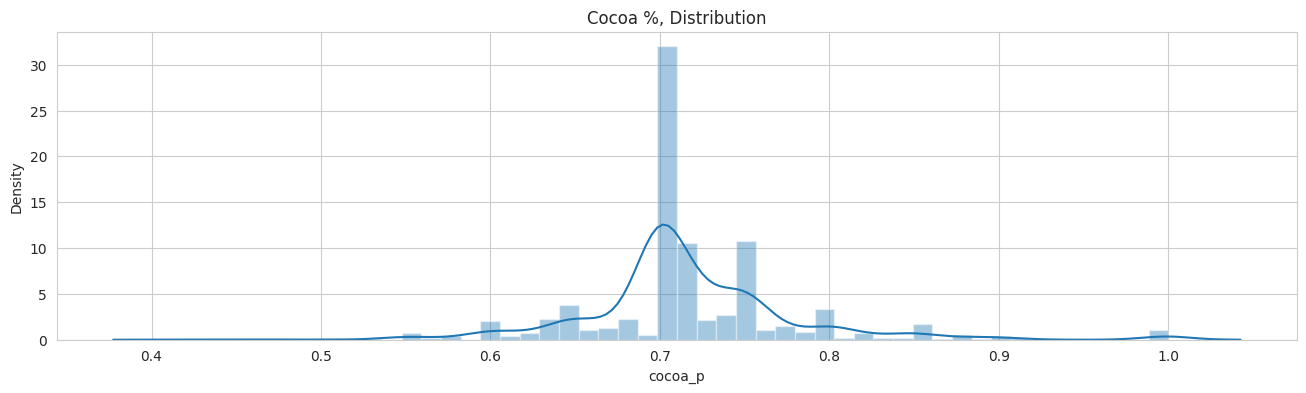

In [432]:
## Look at distribution of Cocoa %
fig, ax = plt.subplots(figsize=[16,4])
sns.distplot(df['cocoa_p'], ax=ax)
ax.set_title('Cocoa %, Distribution')
plt.show()

we can see that most of the bars have coca percent around 0.7

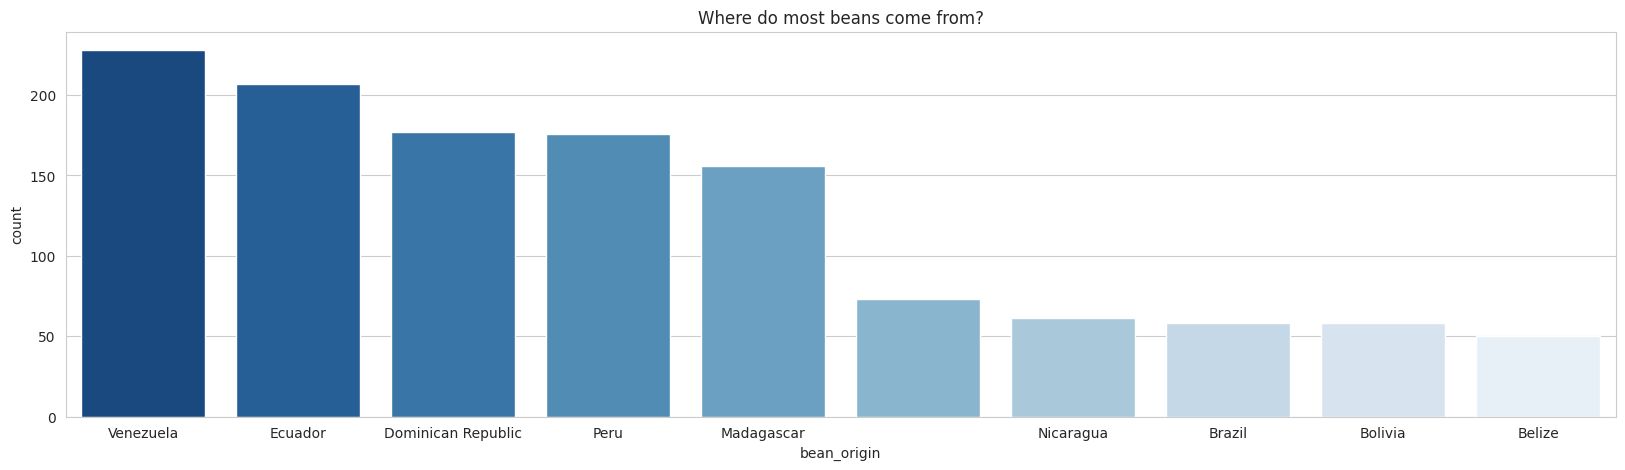

In [433]:
top_counts = df.bean_origin.value_counts().head(10)

plt.figure(figsize=(20, 5))
sns.barplot(x=top_counts.index, y=top_counts.values, hue=top_counts.index, palette="Blues_r", legend=False)
plt.title("Where do most beans come from?")
plt.ylabel("count")
plt.xlabel("bean_origin")
plt.show()

We can see that most of the beans come from Africa and south America countries.

In this section, we exam the best chocolate bar in a broader way, we will take the mean value of the chocolate bar ratings by grouping the origins and company locations. Then we will use the records greater or equal to 10

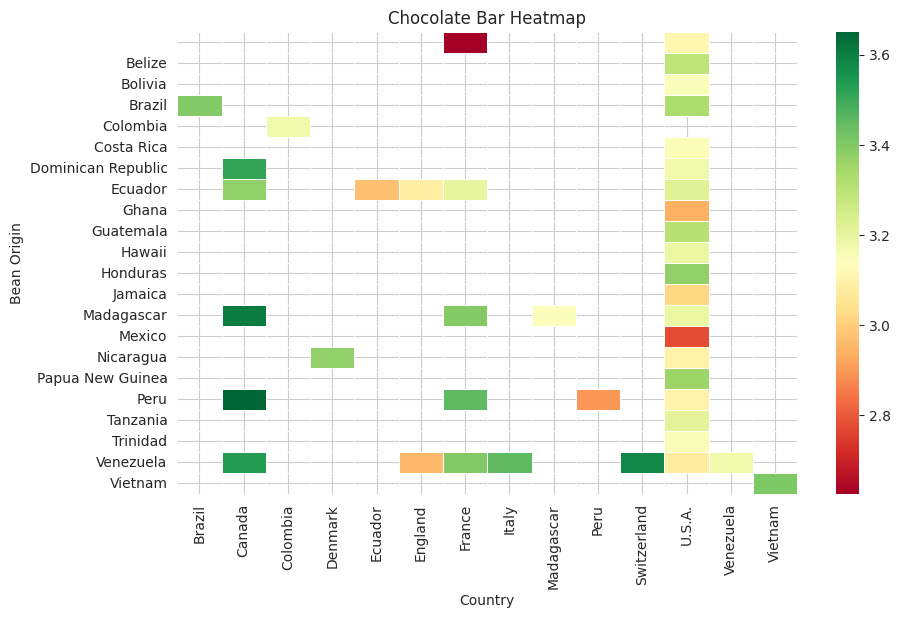

In [434]:
# Group by origin and location, and calculate average rating
grouped = df.groupby(['bean_origin', 'company_location']).agg(count=('rating', 'count'), rate4=('rating', 'mean')).reset_index()

# Filter out counts less than 20
grouped = grouped[grouped['count'] >= 10]

# Pivot the DataFrame to prepare for heatmap
pivot_table = grouped.pivot(index='bean_origin', columns='company_location', values='rate4')

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=False, cmap="RdYlGn", linewidths=.5)
plt.title('Chocolate Bar Heatmap')
plt.xlabel('Country')
plt.ylabel('Bean Origin')
plt.show()

From the heatmap we can see USA produces the most chocolate bars. Whereas Canda produced chocolate with cocao beans originated from Venezuela and Peru has the highest quality. This is consisted with our previous analysis, Canada produce good chocolate while Venezuela and Peru are one of the origins of top cocao Beans.

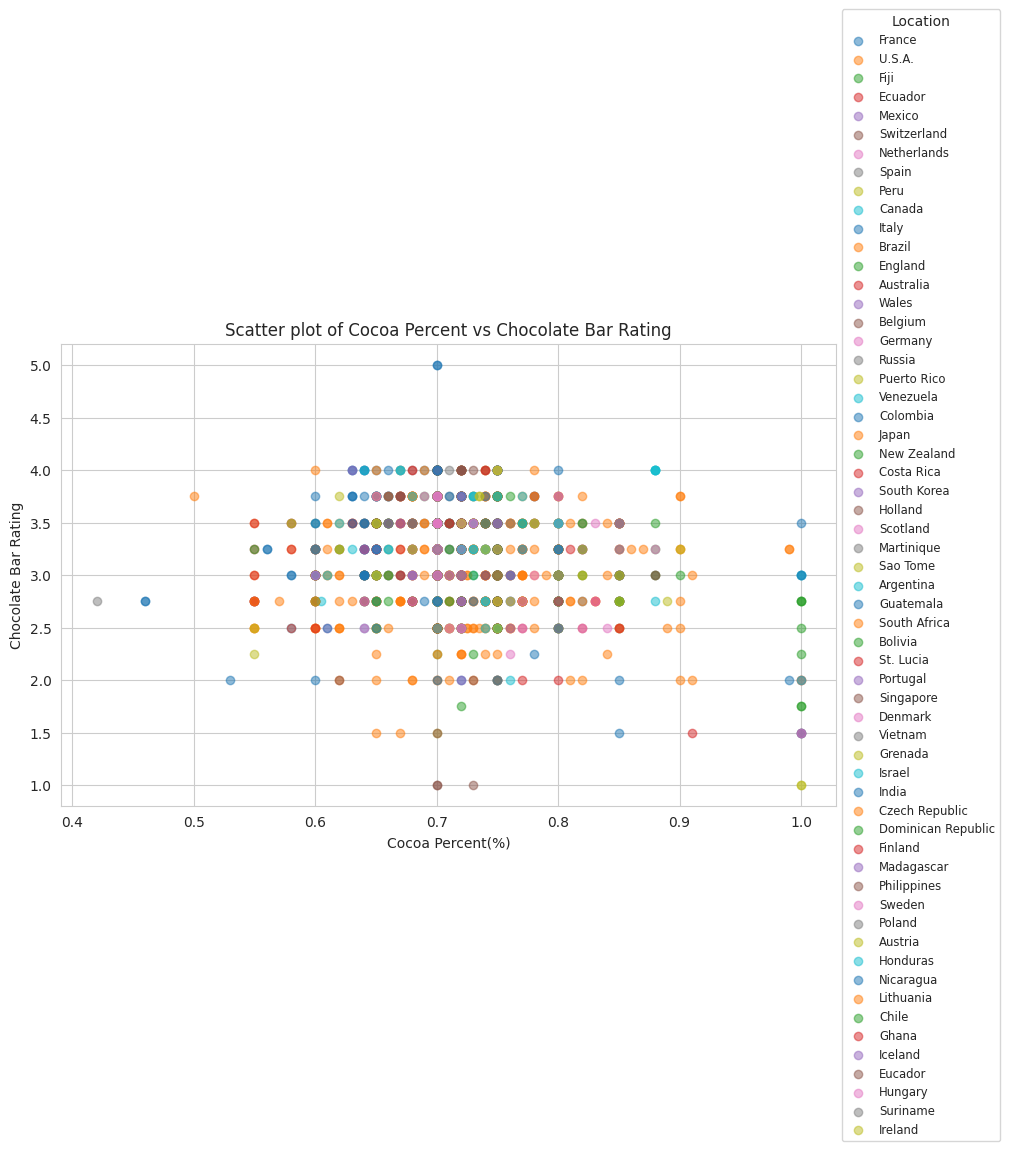

In [435]:
plt.figure(figsize=(10, 6))
for loc in df['company_location'].unique():
    subset = df[df['company_location'] == loc]
    plt.scatter(subset['cocoa_p'], subset['rating'], label=loc, alpha=0.5)

plt.xlabel('Cocoa Percent(%)')
plt.ylabel('Chocolate Bar Rating')
plt.title('Scatter plot of Cocoa Percent vs Chocolate Bar Rating')
plt.legend(title='Location', loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.grid(True)
plt.show()

From this graph we can see when cocao=50% we have the highest average rating. but the case is not persuasive enough. Consider the sample sizes into account, 70% cocao bar still will be the best choice. Moreover, any chocolate bars from 65% - 75% percent cocao looks pretty good and 100% cocoa has lower ratings. In addition we can see that bars from France and Canda have high ratings.

In order to apply correlation plot and to run XGboost on our data we first would like to find all the categorial attributes.
Then, we would like to convert all these features to one-hot encoding.

In [436]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
# Apply label encoding to categorical features
label_encoders = {}
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    df[feature] = label_encoders[feature].fit_transform(df[feature])


Text(0.5, 1.0, 'Correlation Map')

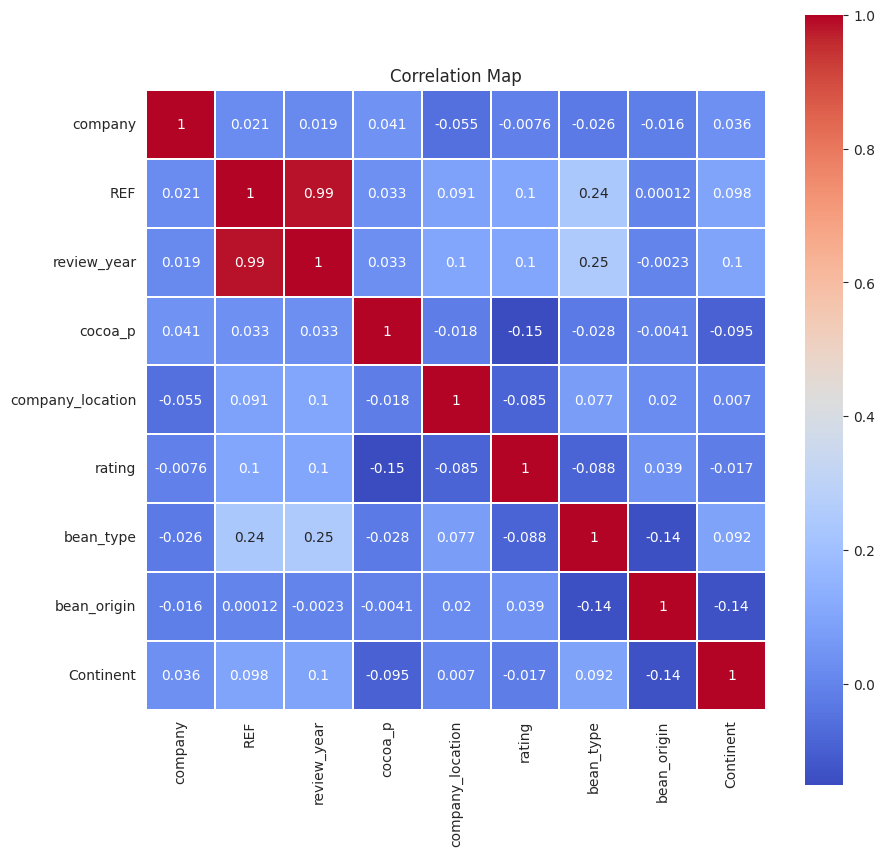

In [437]:
df_without_weight = df.drop(columns=['weight'])
plt.figure(figsize=(10,10))
sns.heatmap(df_without_weight.corr(), linewidths=0.1, vmax=1.0, square=True, cmap='coolwarm', linecolor='white', annot=True).set_title("Correlation Map")

We can see strong correlation between REF and review_year, so we will drop the REF coulmn.

In [438]:
df.drop(['REF'], axis=1, inplace=True)

### Unbalace labels data


In [439]:
# Define a function to categorize ratings
def categorize_rating(rating):
    if rating >= 0 and rating < 1:
        return 1
    elif rating >= 1 and rating < 2:
        return 2
    elif rating >= 2 and rating < 3:
        return 3
    elif rating >= 3 and rating < 4:
        return 4
    elif rating >= 4 and rating <= 5:
        return 5
    elif rating >= 5 and rating <= 6:
        return 6


# Apply the function to create the new categorical rating column
df['categorical_rating'] = df['rating'].apply(categorize_rating)

count the value of each categorial_rating

In [440]:
df['categorical_rating'].value_counts()

categorical_rating
4    1303
3     443
5     114
2      18
Name: count, dtype: int64

We can see that the labels are unbalced so we will need to multiply samples with low count of labels.

In [441]:
# Determine the count of samples for each label
label_counts = df['categorical_rating'].value_counts()

# Determine the maximum count of samples for a label
max_count = label_counts.max()

# Initialize an empty list to store resampled DataFrames
resampled_dfs = []

# Iterate over each label
for label, count in label_counts.items():
    # Calculate the number of samples to resample
    if count < max_count:
        # Resample to match the count of the label with the maximum count
        resampled_df = resample(df[df['categorical_rating'] == label],
                                replace=True,
                                n_samples=max_count - count,
                                random_state=42)
        # Append the resampled DataFrame to the list
        resampled_dfs.append(resampled_df)

# Concatenate the original DataFrame with the resampled DataFrames
balanced_df = pd.concat([df] + resampled_dfs)

# Shuffle the rows in the balanced DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42)
balanced_df['categorical_rating'].value_counts()

categorical_rating
3    1303
4    1303
2    1303
5    1303
Name: count, dtype: int64

In [442]:
# Assigning balanced df to origin df
df = balanced_df

Oversampling, is one common method to balance imbalanced datasets. It involves randomly duplicating samples from the minority classes until the class distribution is balanced. This is a naive appoch and later on we will do other way of oversampling with noise in order to avoid overfitting

# **Outliers**
Outliers can significantly affect the performance of your machine learning model. They can distort the overall distribution of the data, leading to biased model estimates and poor generalization to new data.
They can disproportionately influence the model's coefficients, leading to inaccurate predictions.

In [443]:
df.mean()

company                194.242325
review_year           2011.145434
cocoa_p                  0.750675
company_location        30.212970
rating                   2.843486
bean_type               30.859171
bean_origin             29.855334
Continent                2.660783
weight                   0.936531
categorical_rating       3.500000
dtype: float64

We've decided to exclude the 'weight' and 'ratings' columns from the outliers calculation. This decision was made to avoid disregarding samples with uncommon ratings that are still relevant for prediction. The 'weight' feature, which is normally set to 1 for all samples except those that have been split, is not considered in the outliers calculation. Split samples have a weight less than 1, as explained earlier. Therefore, the 'weight' feature should not influence the identification of outliers, ensuring that split samples are not mistakenly labeled as outliers. It's worth noting that we split samples ourselves to handle cases where one feature contained multiple values. This was done to ensure that each feature had only one value per sample, simplifying the analysis.

In [444]:
def outlier_detaction(df):
  # Exclude 'weight','rating' columns from outlier detection
  columns_to_exclude = ['weight','rating']

  # Calculate z-scores for each column excluding specified columns
  z_scores = df.drop(columns=columns_to_exclude).apply(lambda x: np.abs((x - x.mean()) / x.std()))

  # Set a threshold for outlier detection (e.g., z-score > 3)
  threshold = 3
  outliers = df[(z_scores > threshold).any(axis=1)]

  # Filter outliers from the DataFrame while including the dropped columns
  filtered_df = df.drop(outliers.index)

  print("Original DataFrame:")
  print(df.shape)
  print("\nFiltered DataFrame:")
  print(filtered_df.shape)

  return filtered_df, outliers

A threshold of 3 standard deviations from the mean (z-score > 3) is often used, as it covers about 99.7% of the data in a normal distribution.

In [445]:
balanced_filtered_df, outliers = outlier_detaction(df)
print(f'Number of outliers: {len(outliers)}')

Original DataFrame:
(5212, 10)

Filtered DataFrame:
(5209, 10)
Number of outliers: 3


In [446]:
# Assigning balanced filtered df to origin df
df = balanced_filtered_df

# **Missing value analyze** -
Handaling missing values in data set


Before we fill the missing value in bean_type column accroding to our insight, we'll split our data to train and test so that information from the test set wont be taken into consideration when training.

Now we would separte our samples from the label we want to predict.
Our label is 'categorical_rating'.


In [447]:
def label_processing(df):
  # Map labels to start from 0
  min_label = min(df['categorical_rating'])
  df['categorical_rating'] = df['categorical_rating'] - min_label
  y = df['categorical_rating']

  # Separate features and labels
  X = df.drop(['categorical_rating', 'rating'], axis=1)
  y.value_counts()
  return X, y

In [448]:
# Split the data into training and testing sets
X, y = label_processing(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

Handaling missing values in train set

In [449]:
# Access the mapping for a specific categorical feature
def print_mapping(feature_name):
  if feature_name in label_encoders:
      mapping = dict(zip(label_encoders[feature_name].classes_, label_encoders[feature_name].transform(label_encoders[feature_name].classes_)))
      print(mapping)

In [450]:
print_mapping('bean_type')

{'Amazon': 0, 'Amazon mix': 1, 'Amazon, ICS': 2, 'Beniano': 3, 'Blend': 4, 'Blend-Forastero,Criollo': 5, 'CCN51': 6, 'Criollo': 7, 'Criollo (Amarru)': 8, 'Criollo (Ocumare 61)': 9, 'Criollo (Ocumare 67)': 10, 'Criollo (Ocumare 77)': 11, 'Criollo (Ocumare)': 12, 'Criollo (Porcelana)': 13, 'Criollo (Wild)': 14, 'Criollo, +': 15, 'Criollo, Forastero': 16, 'Criollo, Trinitario': 17, 'EET': 18, 'Forastero': 19, 'Forastero (Amelonado)': 20, 'Forastero (Arriba)': 21, 'Forastero (Arriba) ASS': 22, 'Forastero (Arriba) ASSS': 23, 'Forastero (Catongo)': 24, 'Forastero (Nacional)': 25, 'Forastero (Parazinho)': 26, 'Forastero(Arriba, CCN)': 27, 'Forastero, Trinitario': 28, 'Matina': 29, 'Nacional': 30, 'Nacional (Arriba)': 31, 'Trinitario': 32, 'Trinitario (85% Criollo)': 33, 'Trinitario (Amelonado)': 34, 'Trinitario (Scavina)': 35, 'Trinitario, Criollo': 36, 'Trinitario, Forastero': 37, 'Trinitario, Nacional': 38, 'Trinitario, TCGA': 39, '\xa0': 40, nan: 41}


We can see from the encoder that the numeric values for 'Blend', '\xa0' and nan are 4, 40 and 41 respectively.

In [451]:
"""
X_train['bean_type'] = X_train['bean_type'].replace('\xa0', "Blend")
X_train['bean_type'] = X_train['bean_type'].replace('nan', "Blend")
X_train['bean_type'].value_counts()

The code above is the same as the following code but instead categorial values we have nomeric values:
"""
X_train['bean_type'] = X_train['bean_type'].replace(40, 4)
X_train['bean_type'] = X_train['bean_type'].replace(41, 4)
X_train['bean_type'].value_counts()


bean_type
4     594
32    168
7      82
19     75
21     39
17     21
25     20
13      8
1       6
36      5
22      4
26      3
33      3
3       3
10      3
37      2
2       1
9       1
16      1
31      1
11      1
Name: count, dtype: int64

Replace empty strings in 'bean_origin' column with 'Venezuela' which is the most common bean_origin

In [452]:
print_mapping('bean_origin')

{' ': 0, 'Africa': 1, 'Australia': 2, 'Bali': 3, 'Belize': 4, 'Bolivia': 5, 'Brasil': 6, 'Brazil': 7, 'Burma': 8, 'Cameroon': 9, 'Carribean': 10, 'Central': 11, 'Central America': 12, 'Colombia': 13, 'Congo': 14, 'Costa Rica': 15, 'Cuba': 16, 'Dominican Republic': 17, 'Ecuador': 18, 'El Salvador': 19, 'Fiji': 20, 'Gabon': 21, 'Ghana': 22, 'Grenada': 23, 'Guatemala': 24, 'Haiti': 25, 'Hawaii': 26, 'Honduras': 27, 'India': 28, 'Indonesia': 29, 'Ivory Coast': 30, 'Jamaica': 31, 'Java': 32, 'Liberia': 33, 'Madagascar': 34, 'Malaysia': 35, 'Martinique': 36, 'Mexico': 37, 'Nicaragua': 38, 'Nigeria': 39, 'Panama': 40, 'Pangoa': 41, 'Papua New Guinea': 42, 'Peru': 43, 'Philippines': 44, 'Principe': 45, 'Puerto Rico': 46, 'SMartin': 47, 'Samoa': 48, 'Sao Tome': 49, 'Solomon Islands': 50, 'South America': 51, 'Sri Lanka': 52, 'St Lucia': 53, 'Suriname': 54, 'Tanzania': 55, 'Tobago': 56, 'Togo': 57, 'Trinidad': 58, 'Uganda': 59, 'Vanuatu': 60, 'Venezuela': 61, 'Vietnam': 62, 'West Africa': 63, 'n

We can see the mapping- 'Venezuela': 61, 'nan': 65 and ' ': 0.


In [453]:
"""
X_train['bean_origin'] = X_train['bean_origin'].replace(' ', "Venezuela")
# Replace NaN values in 'bean_origin' column with 'Venezuela'
X_train['bean_origin']=  X_train['bean_origin'].replace("nan", "Venezuela")
X_train['bean_origin'].value_counts()

The code above is the same as the following code but instead categorial values we have nomeric values:
"""

X_train['bean_origin'] = X_train['bean_origin'].replace(0, 61)
# Replace NaN values in 'bean_origin' column with 'Venezuela'
X_train['bean_origin']=  X_train['bean_origin'].replace(65, 61)
X_train['bean_origin'].value_counts()

bean_origin
61    245
18    134
43    111
34     82
17     73
42     29
7      28
49     25
37     23
38     23
5      23
22     21
15     19
45     19
13     17
53     14
62     13
23     12
55     12
31     12
24     12
58     11
25      9
4       9
26      7
10      6
29      6
59      6
63      4
40      4
48      3
20      3
16      2
51      2
19      2
44      2
46      2
30      2
56      2
14      1
27      1
54      1
28      1
11      1
2       1
50      1
64      1
12      1
21      1
52      1
47      1
Name: count, dtype: int64

## **Basic ML Pipeline - XGBoost**

The XGBoost classifier is trained on the training data (X_train and y_train) and used to make predictions on the test data (X_test). Finally, the accuracy of the model is calculated by comparing the predicted labels (y_pred) with the actual labels (y_test).

In addition, in the XGBoost algorithm, we aim to consider the 'weights' feature of samples to ensure that samples with lower weights have less impact compared to samples with a weight of 1. This approach is important because we want the split samples to represent a fraction of the original sample, reflecting their relative importance in the analysis.

In [454]:
def perform_XGboost(X_train, y_train, X_test, y_test):

  # Create an XGBoost classifier
  clf = xgb.XGBClassifier()

  # Convert weight to sample weights
  sample_weights = np.array(X_train['weight'])

  # Train the classifier with sample weights
  model= clf.fit(X_train, y_train, sample_weight=sample_weights)

  # Make predictions
  y_pred = clf.predict(X_test)

  # # Map predictions back to original labels
  # y_pred_original = y_pred + min_label

  # Calculate accuracy
  y_test = y_test.to_numpy()
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy without cross-validation", accuracy)
  return model



# Evaluation metrics:

we calculated statisitics mesurments of
Precision: Proportion of true positives among positive predictions, crucial for avoiding false positives.
Recall: Ability to capture actual positives, important for identifying loan defaults.
F1-score: Harmonic mean of precision and recall, providing a balanced assessment.
Accuracy is a simple and intuitive metric that measures overall correctness. It's suitable when the class distribution is roughly balanced and there is no significant cost difference between false positives and false negatives like in our case. we add  confusion matrix to evaluate our performance because it provides a tabular summary of the number of correct and incorrect predictions made by a classifier for each class. It's useful for understanding the performance of the classifier in more detail.
Now, we will perfome 10-fold cross validation

In [455]:


def ten_fold_cross_validation(X, y, dataset, clf, matrix_print=True):
    # Define the number of folds for k-fold cross-validation
    n_splits = 10

    # Initialize lists to store evaluation scores for each fold
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Initialize a list to store confusion matrices for each fold
    conf_matrices = []

    # Define the cross-validation strategy
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the classifier
        clf.fit(X_train, y_train)

        # Make predictions
        y_pred = clf.predict(X_test)

        # Calculate evaluation scores and append to lists
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='macro'))
        recall_scores.append(recall_score(y_test, y_pred, average='macro'))
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))

        # Calculate confusion matrix and append to list
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrices.append(conf_matrix)

    # Calculate and print the mean evaluation scores across all folds
    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)

    print("Mean Accuracy:", mean_accuracy)
    print("Mean Precision:", mean_precision)
    print("Mean Recall:", mean_recall)
    print("Mean F1-score:", mean_f1)

    if not matrix_print:
        return

    # Ensure all confusion matrices have the same shape
    max_shape = max(matrix.shape for matrix in conf_matrices)
    conf_matrices = [np.pad(matrix, ((0, max_shape[0] - matrix.shape[0]), (0, max_shape[1] - matrix.shape[1])), mode='constant', constant_values=0) for matrix in conf_matrices]

    # Convert conf_matrices to numpy array
    conf_matrices = np.array(conf_matrices)

    # Calculate the mean of all confusion matrices
    average_conf_matrix = np.mean(conf_matrices, axis=0)

    # Plot average confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(average_conf_matrix.astype(int), annot=True, fmt='d', cmap='Blues',
                xticklabels=range(0, 4), yticklabels=range(0, 4))
    plt.title(f'Average Confusion Matrix - {dataset}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()


We want to evaluate our XGBOOST performance on our balanced filtered data.

Accuracy without cross-validation 0.6669865642994242
Mean Accuracy: 0.7839743589743591
Mean Precision: 0.7861866512658379
Mean Recall: 0.7928122266724518
Mean F1-score: 0.7834000177720866


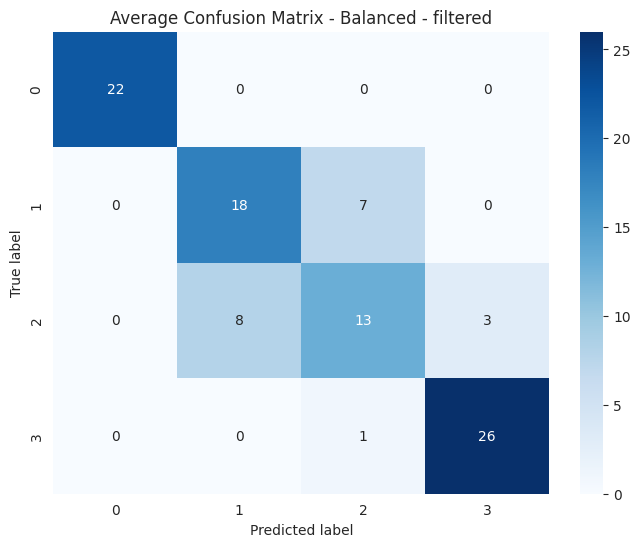

In [456]:
model = perform_XGboost(X_train, y_train, X_test, y_test)
ten_fold_cross_validation(X_train, y_train, 'Balanced - filtered', model)


 Since we don't have a significant distinction between different types of mistakes (false positives and false negatives) in the classification problem, and all misclassifications are equally important, and we have balanced our dataset, then focusing on **accuracy** as the primary evaluation metric may indeed be appropriate.

### **Explain for our results**:
Before the first submission we ran the XGboost algorithm and got Test Accuracy: 0.79510556621881 Validation Accuracy: 0.9191750332201389. The results we got were on train set with the same distribution as test set since we handeled missing values before splitting the data. According to the note we got (that it is a better practice to analyse and impute missing values after splitting to train and test) we splitted the data set before filling the missing values. Thus, our model was trained on a data from a different distribution than the test data. Naturally, the performance of our model would be less accurate.

# **Improve our model**

**Feature importance**

In [457]:
# Get feature importances
feature_importances = model.feature_importances_

for feature, importance in zip(X_train, list(feature_importances)):
  print(f'{feature}: {importance}')

company: 0.07944896817207336
review_year: 0.103121817111969
cocoa_p: 0.18689438700675964
company_location: 0.12446634471416473
bean_type: 0.06414239853620529
bean_origin: 0.06134184077382088
Continent: 0.10317987948656082
weight: 0.2774043679237366


We can see that the lowest importance is the 'weight' feature but we need it for our calculation (since it represets the weight of each splitted sample as explain before). We will drop just 'bean_type' and check if it improves performance.

In [458]:
X_train_temp = X_train.drop(['bean_type'], axis=1)
X_test_temp = X_test.drop(['bean_type'], axis=1)


Accuracy without cross-validation 0.7694337811900192
Mean Accuracy: 0.7695329670329671
Mean Precision: 0.7679761855054263
Mean Recall: 0.7776144835553538
Mean F1-score: 0.7670990933214862


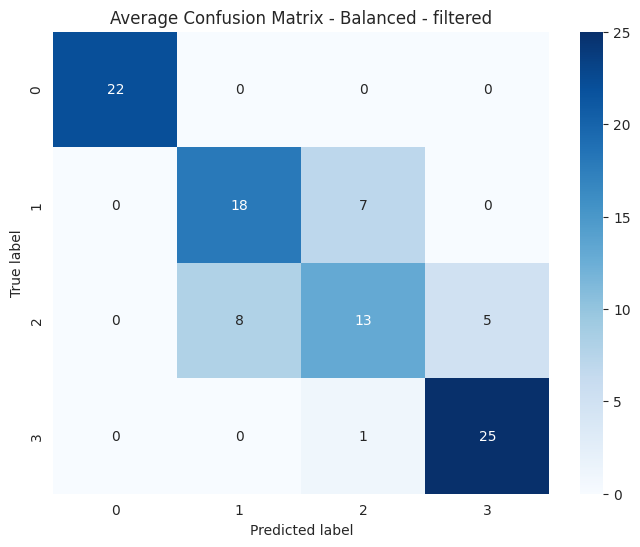

In [459]:
model = perform_XGboost(X_train_temp, y_train, X_test_temp, y_test)
ten_fold_cross_validation(X_train_temp, y_train, 'Balanced - filtered', model)

We can see that our performance now is slightly better.

In [460]:
# Get feature importances
feature_importances = model.feature_importances_

for feature, importance in zip(X_train_temp, list(feature_importances)):
  print(f'{feature}: {importance}')

company: 0.09415535628795624
review_year: 0.11189386248588562
cocoa_p: 0.19683638215065002
company_location: 0.14496371150016785
bean_origin: 0.0668211579322815
Continent: 0.12312796711921692
weight: 0.26220154762268066


In [461]:
X_train_temp = X_train_temp.drop(['bean_origin'], axis=1)
X_test_temp = X_test_temp.drop(['bean_origin'], axis=1)


Accuracy without cross-validation 0.783109404990403
Mean Accuracy: 0.7627655677655678
Mean Precision: 0.761086321753211
Mean Recall: 0.7674590848994015
Mean F1-score: 0.7573727118685134


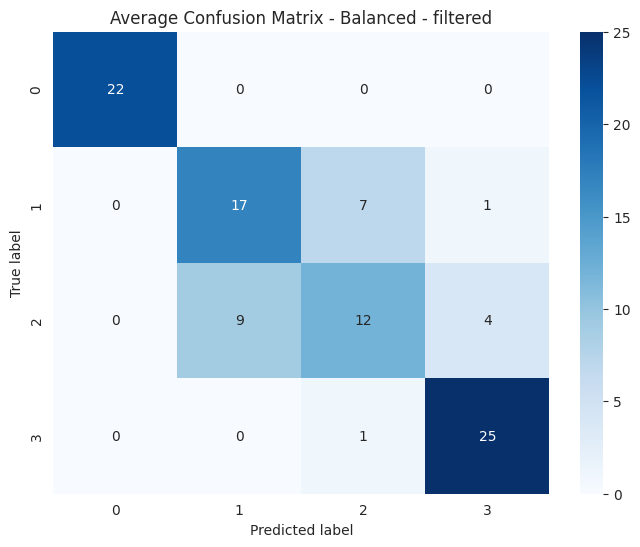

In [462]:
model = perform_XGboost(X_train_temp, y_train, X_test_temp, y_test)
ten_fold_cross_validation(X_train_temp, y_train, 'Balanced - filtered', model)

**improve our ML model BY GBM**

Gradient Boosting Machines (GBM): GBM algorithms like CatBoost build trees sequentially, where each tree corrects errors made by the previous one, potentially leading to better overall performance.

In [463]:


# Define CatBoost parameters
catboost_params = {
    'iterations': 100,                  # Number of boosting iterations
    'learning_rate': 0.1,               # Learning rate
    'depth': 6,                         # Depth of the trees
    'loss_function': 'MultiClass',      # Loss function for multi-class classification
    'eval_metric': 'Accuracy',          # Evaluation metric
    'random_seed': 42   ,
     'verbose': False # Random seed for reproducibility
}

# Create CatBoost classifier
catboost_model = CatBoostClassifier(**catboost_params)

# Train the model
catboost_model.fit(X_train_temp, y_train)

# Make predictions on the test set
y_pred_catboost = catboost_model.predict(X_test_temp)

# Evaluate accuracy
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print("Accuracy:", accuracy_catboost)


Accuracy: 0.7068138195777351


We got better results using XGBoost so we will try to do hyper parametrs tuning for XGBOOST model in order to improve the resultls.

**Hyper-Parameter Tuning XGBOOST**

In [464]:

def perform_best_XGboost(X_train, y_train, X_test, y_test):

    # Create an XGBoost classifier
    clf = xgb.XGBClassifier()

    # Define hyperparameters grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 10, 12],
        'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
    }

    # Convert weight to sample weights
    sample_weights = np.array(X_train['weight'])

    # Perform grid search
    grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)

    # Get the best model from grid search
    best_clf = grid_search.best_estimator_

    # Make predictions
    y_pred = best_clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)


    print("Best Parameters:", grid_search.best_params_)
    print("Accuracy:", accuracy)


    return best_clf,y_pred


In [465]:
model ,y_pred= perform_best_XGboost(X_train_temp, y_train, X_test_temp, y_test)




Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Accuracy: 0.7804702495201535


### **Analyze the final model performance**

Using SHAP -  SHAP (SHapley Additive exPlanations) is a method used in machine learning for understanding the output of black-box models. It provides explanations for individual predictions by attributing the prediction outcome to different features in the input data. SHAP values assign each feature an importance value for a particular prediction.

Calculating SHAP values

In [466]:

explainer = shap.Explainer(model, X_train_temp)

# Compute SHAP values
shap_values = explainer(X_train_temp)


100%|===================| 4156/4164 [03:52<00:00]       

In [467]:
np.shape(shap_values)

(1041, 6, 4)

Since we have multiclass we visualize the shap value manually, firstly, we generate waterfall plots for the SHAP values of a single sample. Considering only the SHAP values for individual features across different classes.

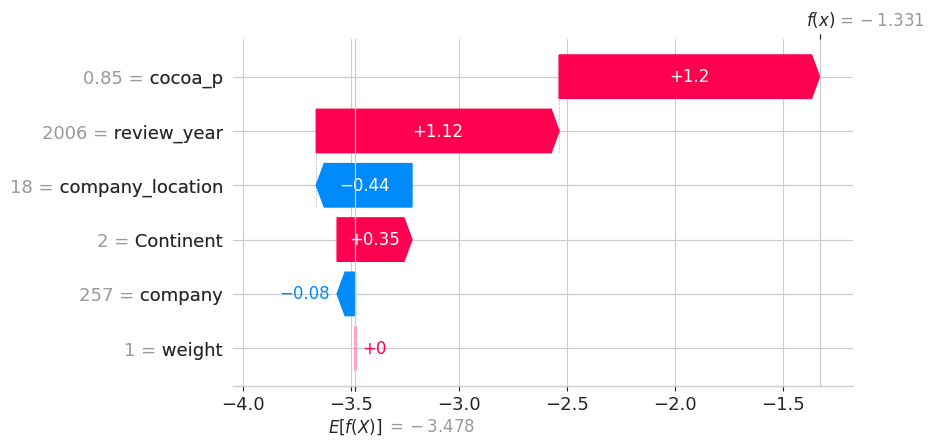

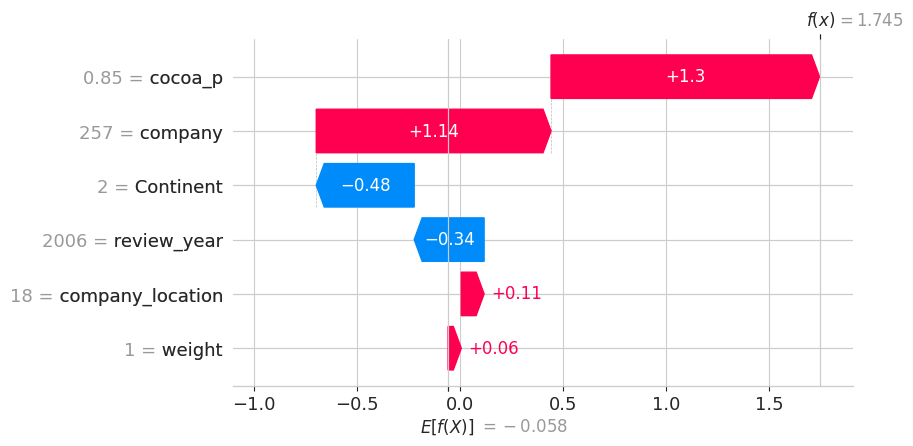

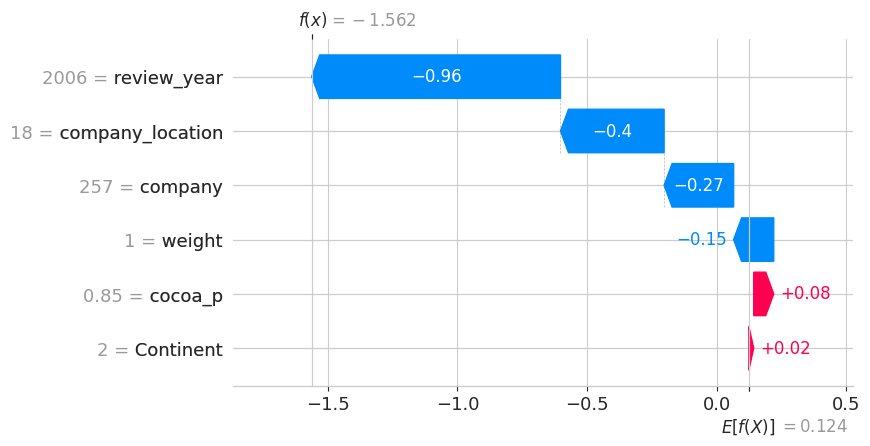

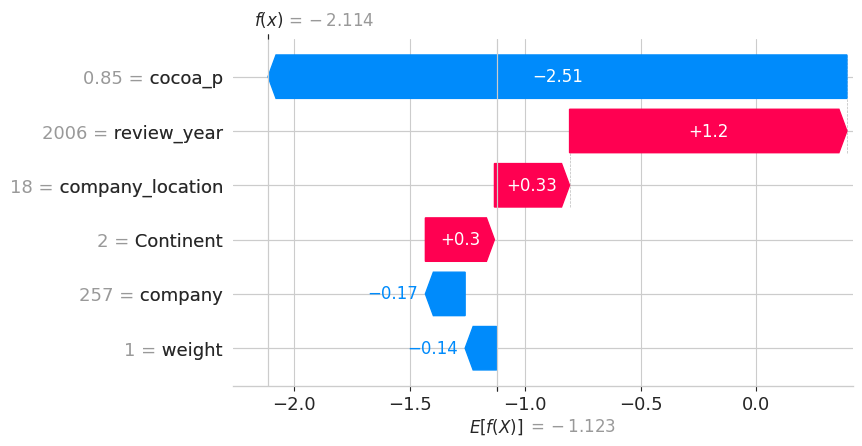

In [468]:
shap.plots.waterfall(shap_values[0, : ,0])
shap.plots.waterfall(shap_values[0, : ,1])
shap.plots.waterfall(shap_values[0, : ,2])
shap.plots.waterfall(shap_values[0, : ,3])

We can see the shap plot for each class, the improtance of features across classes. Let's visualize the mean SHAP values across all samples

In [469]:
mean_0=np.mean(np.abs(shap_values.values[:,:,0]),axis=0)
mean_1=np.mean(np.abs(shap_values.values[:,:,1]),axis=0)
mean_2=np.mean(np.abs(shap_values.values[:,:,2]),axis=0)
mean_3=np.mean(np.abs(shap_values.values[:,:,3]),axis=0)

Plot the result

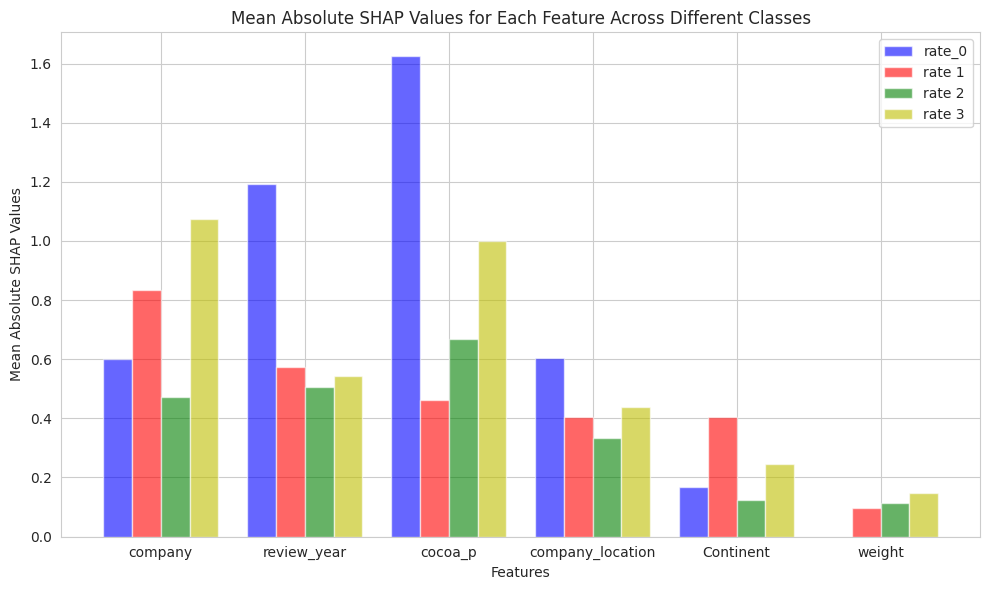

In [470]:
# Plot mean absolute SHAP values for each feature
num_features = len(mean_0)
feature_names = X_train_temp.columns  # Assuming X_train_temp is a DataFrame with feature names

fig, ax = plt.subplots(figsize=(10, 6))

index = np.arange(num_features)
bar_width = 0.2

opacity = 0.6
error_config = {'ecolor': '0.3'}

bar0 = ax.bar(index, mean_0, bar_width, alpha=opacity, color='b', label='rate_0')
bar1 = ax.bar(index + bar_width, mean_1, bar_width, alpha=opacity, color='r', label='rate 1')
bar2 = ax.bar(index + 2 * bar_width, mean_2, bar_width, alpha=opacity, color='g', label='rate 2')
bar3 = ax.bar(index + 3 * bar_width, mean_3, bar_width, alpha=opacity, color='y', label='rate 3')

ax.set_xlabel('Features')
ax.set_ylabel('Mean Absolute SHAP Values')
ax.set_title('Mean Absolute SHAP Values for Each Feature Across Different Classes')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(feature_names)
ax.legend()

plt.tight_layout()
plt.show()

From the plot we can see the mean shap value accross the featuresfor each class. For example we can see that for class-rate_0 there is high mean shap with cocoa_p feature.  

# **Error Analyze:**
This could indicate areas where the model needs improvement, such as feature engineering, data preprocessing, or model tuning.

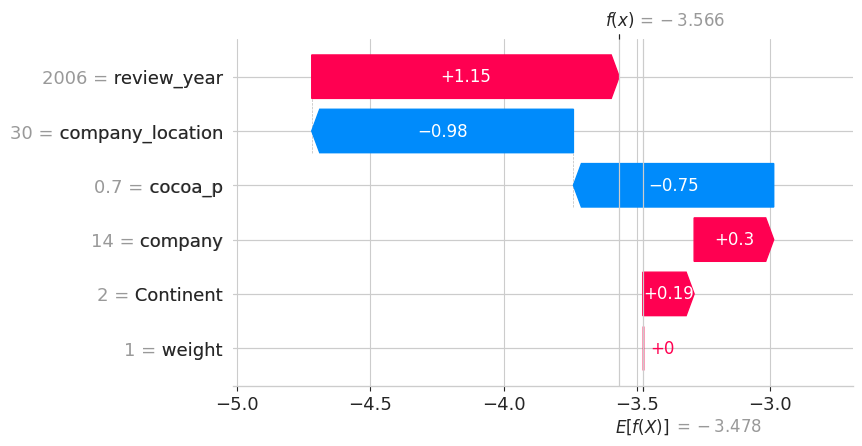

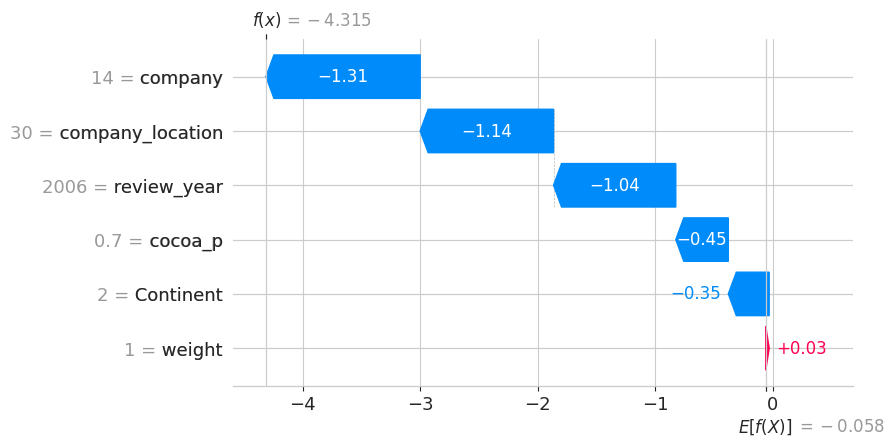

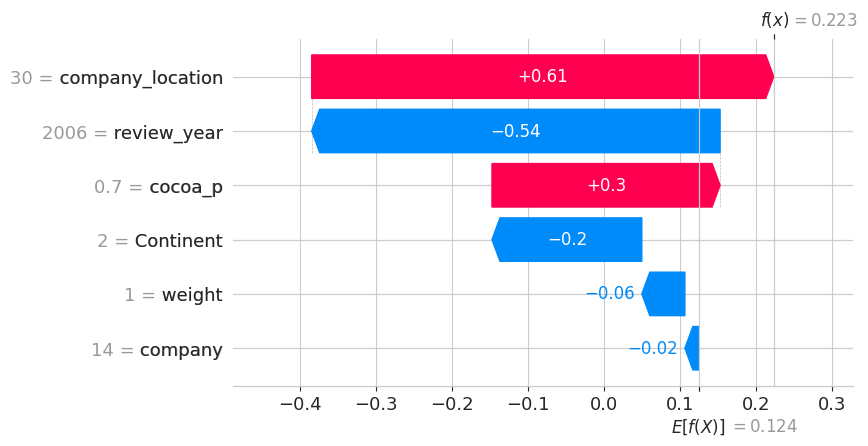

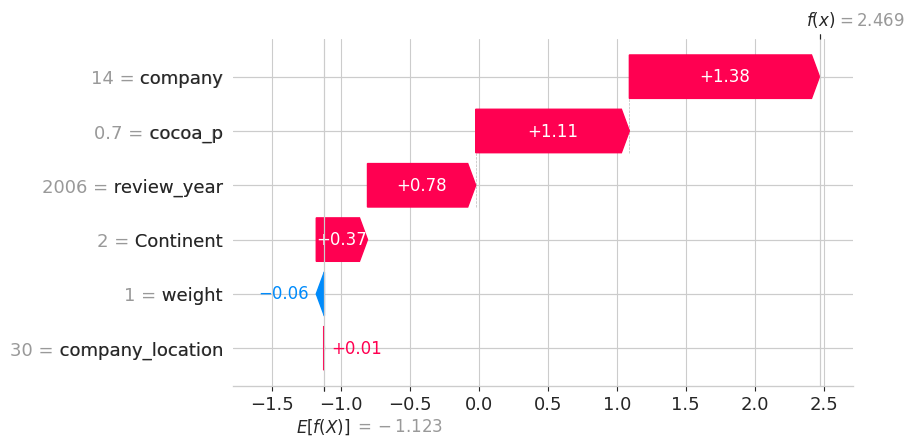

In [471]:
incorrect_predictions = X_test_temp[y_test != y_pred]
incorrect_indices = [i for i in range(len(y_test)) if y_test.iloc[i] != y_pred[i]]


shap.plots.waterfall(shap_values[incorrect_indices[0], : ,0])
shap.plots.waterfall(shap_values[incorrect_indices[0], : ,1])
shap.plots.waterfall(shap_values[incorrect_indices[0], : ,2])
shap.plots.waterfall(shap_values[incorrect_indices[0], : ,3])


We're having trouble identifying a clear pattern that led to the error. Our suspicion is that due to the limited size of our dataset, the model may be underfitting.

We aimed to enhance our machine learning model by incorporating feature selection and hyperparameter tuning. Our initial model was built on a meticulously preprocessed dataset, where we balanced the classes, removed outliers, and conducted extensive feature engineering. However, we suspect that the relatively small size of our dataset may have limited our model's performance. Despite these challenges, We tried to improve the basic ML algorithm using feature selectiom, and hyper parameter tunining and got small improvment.

# **Conclustion**
We've explored numerous notebooks dedicated to this dataset, drawing inspiration from others' exploratory data analyses (EDAs). However, we've enriched our pipeline with crucial steps tailored to our specific needs. Firstly, during the preprocessing phase, we delved into feature engineering. Given the inconsistent *values* in certain columns of the dataset, we meticulously handled outliers and balanced classes by introducing a weight column. We pruned uninformative columns and addressed missing values by thoroughly understanding the data and inferring relevant values. Each column's meaning was carefully interpreted, and missing values were imputed with the most plausible values, enhancing the overall robustness of our preprocessing pipeline.

# **References**
NOTEBOOK FOR ANALYZE DATASETS-
https://www.kaggle.com/code/viannaandresouza/eda-chocolate-bar-ratings-analysis-statistic
https://www.kaggle.com/code/noderaider/chocolate-bar-ratings-report
https://www.kaggle.com/code/tibhar940/chocolate-bar-ratings-python-eda-dataviz
https://www.kaggle.com/code/bansalvishesh/eda-on-chocolate-dataset
https://www.kaggle.com/code/iamyajat/eda-and-cleaning-chocolate-ratings#EDA
https://www.kaggle.com/code/sharanya02/exploring-chocolate-bar-ratings#Categorizing-chocolate-bars-based-on-their-rating

ADDITIONAL WEBSITWS WE USE-
https://xgboost.readthedocs.io/en/stable/
https://shap.readthedocs.io/en/latest/
